In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# IMPT: make shortcut of the BT4012 Project folder inside your google drive so the stuff below works
drive.mount("/content/drive")
trainData = pd.read_csv("/content/drive/My Drive/BT4012 Project/fraudTrain.csv")
testData = pd.read_csv("/content/drive/My Drive/BT4012 Project/fraudTest.csv")

allData = pd.concat([trainData, testData])

Mounted at /content/drive


# Data Pre-processing

In [2]:
def age_group(row):
    rows = row["age"]
    if rows <20:
        return "less than 20"
    elif rows >=20 and rows<30:
        return "20 to 30"
    elif rows >=30 and rows<40:
        return "30 to 40"
    elif rows >=40 and rows<50:
        return "40 to 50"
    elif rows >=50 and rows<60:
        return "50 to 60"
    elif rows >=60 and rows<70:
        return "60 to 70"
    elif rows >=70 and rows<80:
        return "70 to 80"
    elif rows >=80 and rows<90:
        return "80 to 90"
    else:
        return "greater than 90"

In [3]:
# Check null
count_na = allData.isna().sum().sum() 
print('Count of Na: ' + str(count_na)) # No null values

Count of Na: 0


In [4]:
# Check duplicates
is_false = allData.duplicated().any()
print('Any duplicates?: ' + str(is_false)) # No duplicates so no need drop

Any duplicates?: False


In [5]:
from sklearn.model_selection import train_test_split

# age grp
allData["age"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).year-pd.DatetimeIndex(allData["dob"]).year
allData["age_group"] = allData.apply(age_group,axis=1)

# trans times / age
allData["trans_hour"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).hour
allData["trans_yrmth"] = pd.DatetimeIndex(allData['trans_date_trans_time']).strftime('%Y-%m')
allData["weekday"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).weekday
allData["date"] = pd.to_datetime(allData['trans_date_trans_time']).dt.date

# drop redundant index column
allData.drop(labels="Unnamed: 0", axis=1, inplace=True)

# calculating the distance between the merchant location and transaction location
allData["latitude_difference"] = abs(allData["lat"]-allData["merch_lat"])
allData["longitude_difference"] = abs(allData["long"]-allData["merch_long"])

# it is estimated that difference between each degree of longitude and lattitude is approximately 69 miles which is 110 km
# applying pythogoras theorem
allData["distance"] = np.sqrt(pow(allData["latitude_difference"]*110,2)+pow(allData["longitude_difference"]*110,2))
allData['distance'].describe()

allData.category = allData.category.astype("category")
allData.gender = allData.gender.astype("category")
allData.state = allData.state.astype("category")
allData.age_group = allData.age_group.astype("category")
allData.trans_yrmth = allData.trans_yrmth.astype("category")
allData.weekday = allData.weekday.astype("category")
allData.job = allData.job.astype("category")
allData.city = allData.city.astype("category")
allData.is_fraud = allData.is_fraud.astype("category")
allData.trans_hour = allData.trans_hour.astype("category")

#can ignore others, just use train, validation, test
train, others = train_test_split(allData, test_size=0.2, random_state=4012)
del(allData)
validation, test = train_test_split(others, test_size=0.5, random_state=4012)
del(others)

onlyFraud = train[train.is_fraud == 1]
noFraud = train[train.is_fraud != 1]

print(onlyFraud)

       trans_date_trans_time            cc_num  \
288598   2019-05-21 23:40:29  6011438889172900   
644699   2019-10-01 01:45:49   346208242862904   
366597   2019-06-19 01:11:01  6506116513503136   
621562   2019-09-21 17:41:09  3565943051129759   
10057    2019-01-07 04:34:48  3597980945245815   
...                      ...               ...   
205282   2019-04-15 03:05:13  3548710338694745   
389704   2020-11-21 03:17:38    30235268718158   
204807   2020-09-01 01:10:19  4003989662068504   
93343    2019-02-24 22:33:25   180036456789979   
351029   2019-06-14 00:17:50  6011948324228984   

                                  merchant       category     amt      first  \
288598                fraud_Abbott-Steuber  personal_care   20.17    Allison   
644699                   fraud_Collier Inc    grocery_net   10.54    Tabitha   
366597               fraud_Dooley-Thompson       misc_net  773.63   Kimberly   
621562                     fraud_Lynch Ltd   shopping_pos  905.66      David   

# Inspecting Data

In [6]:
print('Train Data Size: ' + str(train.shape))

Train Data Size: (1481915, 31)


In [7]:
# Data type for all fields
train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481915 entries, 1089385 to 1153294
Data columns (total 31 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   trans_date_trans_time  1481915 non-null  object  
 1   cc_num                 1481915 non-null  int64   
 2   merchant               1481915 non-null  object  
 3   category               1481915 non-null  category
 4   amt                    1481915 non-null  float64 
 5   first                  1481915 non-null  object  
 6   last                   1481915 non-null  object  
 7   gender                 1481915 non-null  category
 8   street                 1481915 non-null  object  
 9   city                   1481915 non-null  category
 10  state                  1481915 non-null  category
 11  zip                    1481915 non-null  int64   
 12  lat                    1481915 non-null  float64 
 13  long                   1481915 non-null  float64 
 

In [8]:
# Statistics of data
train.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,age,latitude_difference,longitude_difference,distance
count,1.481915e+06,1.481915e+06,1.481915e+06,1.481915e+06,1.481915e+06,1.481915e+06,1.481915e+06,1.481915e+06,1.481915e+06,1.481915e+06,1.481915e+06,1.481915e+06,1.481915e+06
mean,4.168644e+17,7.005187e+01,4.880625e+04,3.854127e+01,-9.022216e+01,8.883593e+04,1.358675e+09,3.854062e+01,-9.022223e+01,4.620286e+01,5.003098e-01,5.004165e-01,8.423434e+01
std,1.308338e+18,1.589593e+02,2.687404e+04,5.071644e+00,1.374271e+01,3.020596e+05,1.819331e+07,5.105922e+00,1.375470e+01,1.738620e+01,2.885954e-01,2.888299e-01,3.131385e+01
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,1.400000e+01,0.000000e+00,0.000000e+00,2.625292e-02
25%,1.800429e+14,9.650000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343020e+09,3.474357e+01,-9.688966e+01,3.300000e+01,2.503115e-01,2.501165e-01,6.215095e+01
50%,3.521417e+15,4.746000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357120e+09,3.936713e+01,-8.743867e+01,4.400000e+01,5.007580e-01,5.006330e-01,8.781654e+01
75%,4.642255e+15,8.309000e+01,7.201100e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374572e+09,4.195652e+01,-8.024408e+01,5.700000e+01,7.501835e-01,7.505380e-01,1.075201e+02
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,9.600000e+01,9.999990e-01,9.999990e-01,1.554701e+02


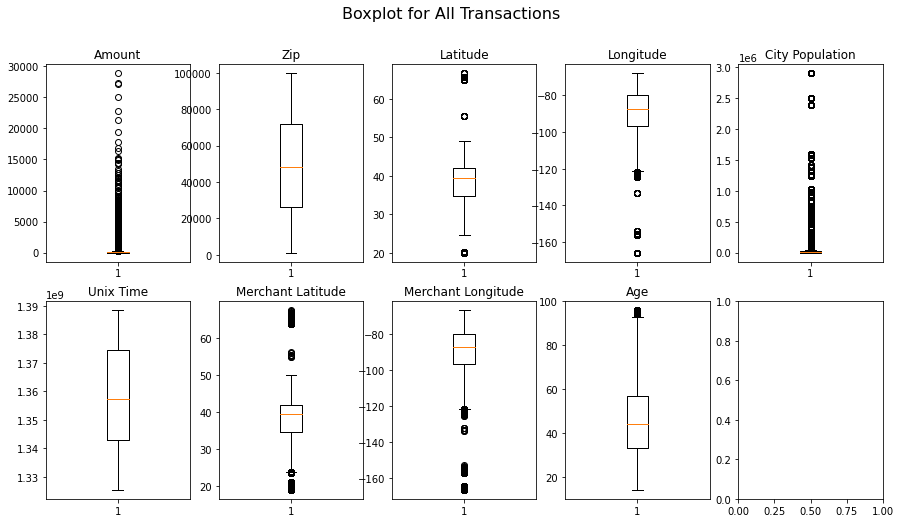

In [9]:
# Boxplot to check for outliers

fig, axs = plt.subplots(2, 5, figsize=(15, 8))

axs[0, 0].boxplot(train['amt'])
axs[0, 0].set_title('Amount')

axs[0, 1].boxplot(train['zip'])
axs[0, 1].set_title('Zip')

axs[0, 2].boxplot(train['lat'])
axs[0, 2].set_title('Latitude')

axs[0, 3].boxplot(train['long'])
axs[0, 3].set_title('Longitude')

axs[0, 4].boxplot(train['city_pop'])
axs[0, 4].set_title('City Population')

axs[1, 0].boxplot(train['unix_time'])
axs[1, 0].set_title('Unix Time')

axs[1, 1].boxplot(train['merch_lat'])
axs[1, 1].set_title('Merchant Latitude')

axs[1, 2].boxplot(train['merch_long'])
axs[1, 2].set_title('Merchant Longitude')

axs[1, 3].boxplot(train['age'])
axs[1, 3].set_title('Age')

fig.suptitle('Boxplot for All Transactions', fontsize=16)
plt.show()

Amount and City Population have many outliers.

# EDA

In [10]:
train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'age', 'age_group', 'trans_hour',
       'trans_yrmth', 'weekday', 'date', 'latitude_difference',
       'longitude_difference', 'distance'],
      dtype='object')

## Amount

Statistics of Amount for Fraud Transactions:
count    7706.000000
mean      528.686620
std       391.552342
min         1.060000
25%       237.902500
50%       377.210000
75%       902.252500
max      1376.040000
Name: amt, dtype: float64

Statistics of Amount for Non-Fraud Transactions:
count    1.474209e+06
mean     6.765449e+01
std      1.532762e+02
min      1.000000e+00
25%      9.610000e+00
50%      4.726000e+01
75%      8.257000e+01
max      2.894890e+04
Name: amt, dtype: float64

99th Percentile of Amount for Fraud Transactions: 1177.7825

99th Percentile of Amount for Non-Fraud Transactions: 484.55


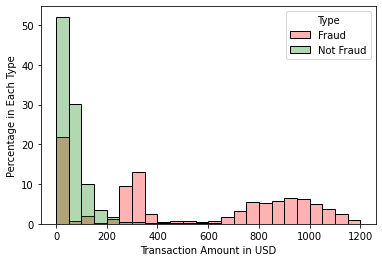

In [11]:
# view statistics for 'amt'
print('Statistics of Amount for Fraud Transactions:')
print(onlyFraud['amt'].describe())
print('\n' + 'Statistics of Amount for Non-Fraud Transactions:')
print(noFraud['amt'].describe())

# view 99th percentile for 'amt'
print('\n' + '99th Percentile of Amount for Fraud Transactions: ' + str(np.percentile(onlyFraud['amt'], 99)))
print('\n' + '99th Percentile of Amount for Non-Fraud Transactions: ' + str(round(np.percentile(noFraud['amt'], 99), 2)))

# due to outliers, we will limit the scale of 'amt' to the 99th percentile
bins = np.linspace(0, 1200, 25)
ax=sns.histplot(onlyFraud.amt,stat='percent',color="red",alpha=0.3,multiple='dodge',common_norm=False,bins=bins)
ax=sns.histplot(noFraud.amt,stat='percent',color="green",alpha=0.3,multiple='dodge',common_norm=False,bins=bins)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

From the histogram above, it can be observed that a high majority of non-fraudulent transactions have transaction amounts of \$200 or less, whereas fraudulent transactions can go up to \$1200. This shows a clear distinction in terms of transaction amount between normal and fraudulent transactions. 

Similarly, from the statistics above, we can see the the mean transaction amount for fraudulent transactions is much higher than that of non-fraudulent transactions.

In [12]:
amt_outliers = train[train["amt"] > 1000]
amt_outliers["is_fraud"].value_counts()

0    3423
1     972
Name: is_fraud, dtype: int64

We can see that for extreme values of `amount`, the proportion of transactions that are fraud is a lot higher (almost a quarter of all transactions above $1000 are fraudulent).

## State

   State  Total Count  Fraud Count  Percentage Fraud
50    DE            7            7             100.0


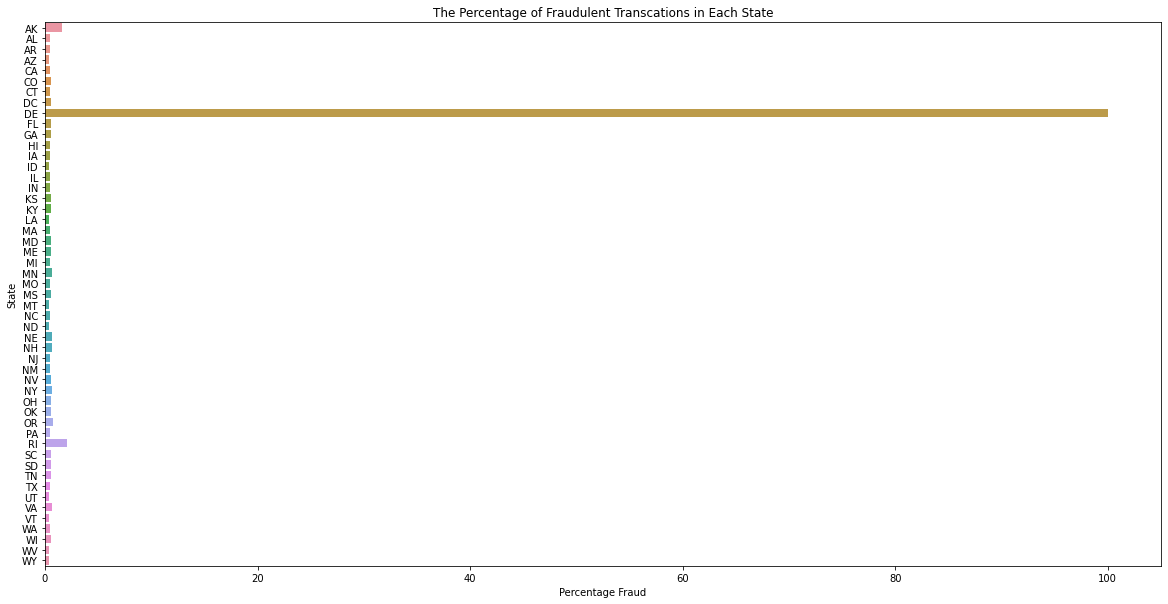

In [13]:
# creating df with total number of transaction count for each state
a=train.state.value_counts()
a=a.to_frame()
a=a.reset_index()
a.columns = ['State', 'Total Count']

# creating df with number of fraudulent transactions for each state
b=onlyFraud.state.value_counts()
b=b.to_frame()
b=b.reset_index()
b.columns = ['State', 'Fraud Count']

# merging the two df and finding percentage of fraudulent transactions for each state
merged=a.merge(b,on='State')
merged['Percentage Fraud']=merged['Fraud Count']/merged['Total Count']
merged['Percentage Fraud']=merged['Percentage Fraud']*100
merged=merged.sort_values('Percentage Fraud',ascending=False)

plt.figure(figsize = [20,10])
ax1=sns.barplot(data=merged, x='Percentage Fraud',y='State')
ax1.set_xlabel('Percentage Fraud')
ax1.set_ylabel('State')
plt.title('The Percentage of Fraudulent Transcations in Each State')
print(merged[merged.State=="DE"])

State DE has 100% Fraud Transactions because its total transaction count is only 9, hence it is an outlier. The rest of the states have transaction counts in the thousands (except RI with 745, but considered large enough). Hence, it is possible to remove DE from the data to get more distinct results.

Text(0.5, 1.0, 'The Percentage of Fraudulent Transcations in Each State')

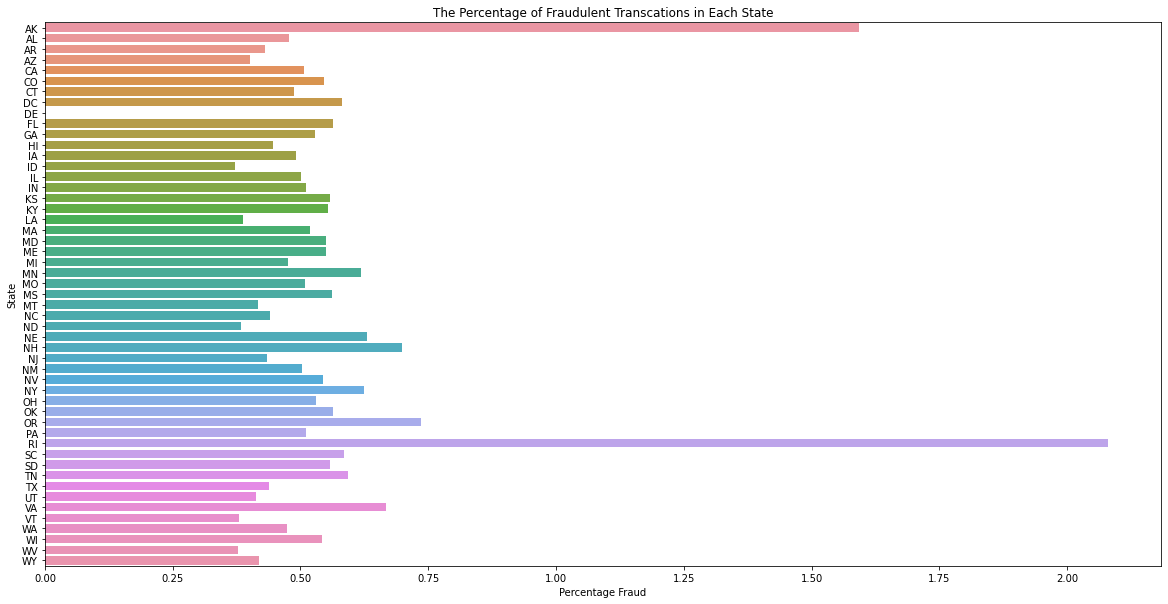

In [14]:
# drop state DE
merged = merged.loc[merged["State"] != "DE"]

plt.figure(figsize=[20,10])
ax1=sns.barplot(data=merged, x='Percentage Fraud',y='State')
ax1.set_xlabel('Percentage Fraud')
ax1.set_ylabel('State')
plt.title('The Percentage of Fraudulent Transcations in Each State')

RI and AK have a significantly higher percentage of fraud transactions.

In [15]:
fraudGroup = onlyFraud.groupby("state", as_index=False).agg({"amt": "count"})
noFraudGroup = noFraud.groupby("state", as_index=False).agg({"amt": "count"})
fraudGroup = fraudGroup[fraudGroup.state != "DE"] # drop DE
groupedState = fraudGroup.merge(noFraudGroup, on="state", suffixes=["_x", "_y"])
groupedState["amt"] = groupedState.amt_x / (groupedState.amt_x + groupedState.amt_y)

fig = px.choropleth(groupedState,
                    locations='state',
                    color='amt',
                    color_continuous_scale='Geyser',
                    hover_name='state',
                    locationmode='USA-states',
                    labels={'amt':'Proportion of Fraud in Number of Transactions'},
                    scope='usa')
fig.show()

Here, we see the same information in a geographical context.

## City

                          City  Total Count  Fraud Count  Percentage Fraud
655                 Clearwater          616           24          3.896104
656                     Aurora          614           19          3.094463
739                        Jay          590           16          2.711864
823                     Benton          572           15          2.622378
736                     Moscow          590           15          2.542373
741                    Boulder          590           14          2.372881
727                     Girard          591           14          2.368866
666                    Chatham          606           14          2.310231
757                 Burns Flat          588           13          2.210884
754                  Riverview          589           13          2.207131
688                  Rock Glen          599           13          2.170284
679              Saint Francis          602           13          2.159468
805                 Provi

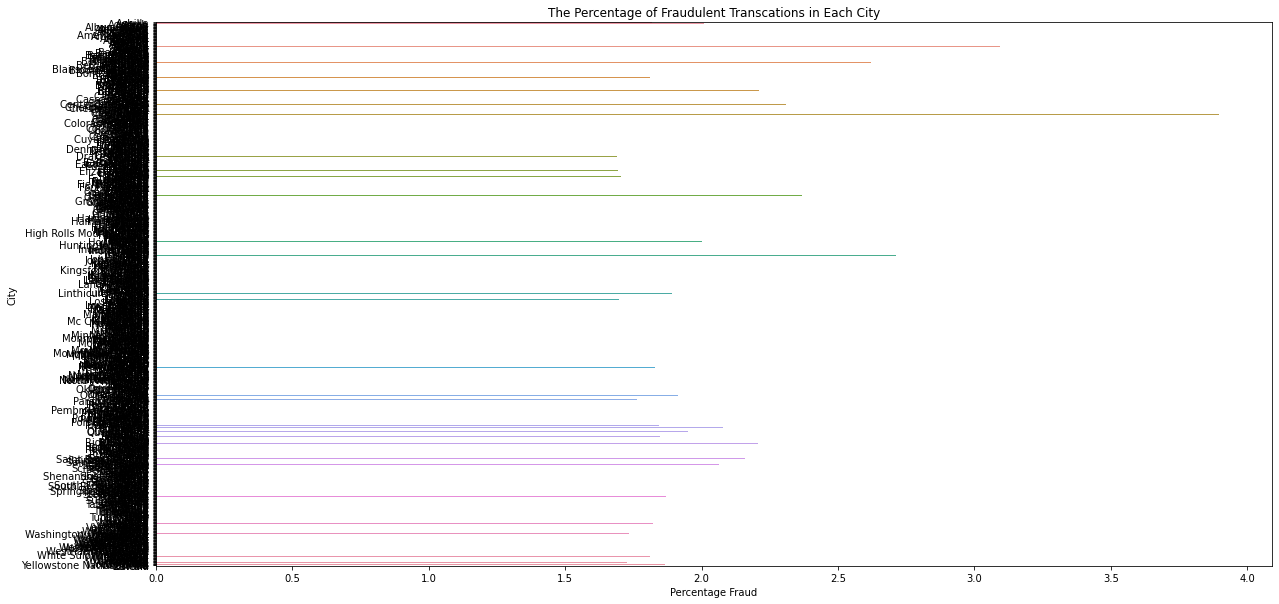

In [16]:
# creating df with total number of transaction count for each city
c=train.city.value_counts()
c=c.to_frame()
c=c.reset_index()
c.columns = ['City', 'Total Count']

# creating df with number of fraudulent transactions for each city
d=onlyFraud.city.value_counts()
d=d.to_frame()
d=d.reset_index()
d.columns = ['City', 'Fraud Count']

# merging the two df and finding percentage of fraudulent transactions for each city
merged2=c.merge(d,on='City')
merged2['Percentage Fraud']=merged2['Fraud Count']/merged2['Total Count']
merged2['Percentage Fraud']=merged2['Percentage Fraud']*100
merged2=merged2.sort_values('Percentage Fraud',ascending=False)

# ignore those cities with too low total count
# TODO: should we drop those cities?
merged2=merged2.loc[merged2["Total Count"] > 100]

# since there are too many cities, we only look at the top 50 with the highest percentage of fraudulent transactions
merged2=merged2[:50]

plt.figure(figsize = [20,10])
ax1=sns.barplot(data=merged2, x='Percentage Fraud',y='City')
ax1.set_xlabel('Percentage Fraud')
ax1.set_ylabel('City')
plt.title('The Percentage of Fraudulent Transcations in Each City')
print(merged2)

Cities Clearwater, Benton and Aurora have the highest percentage of fraud transactions.

## Job

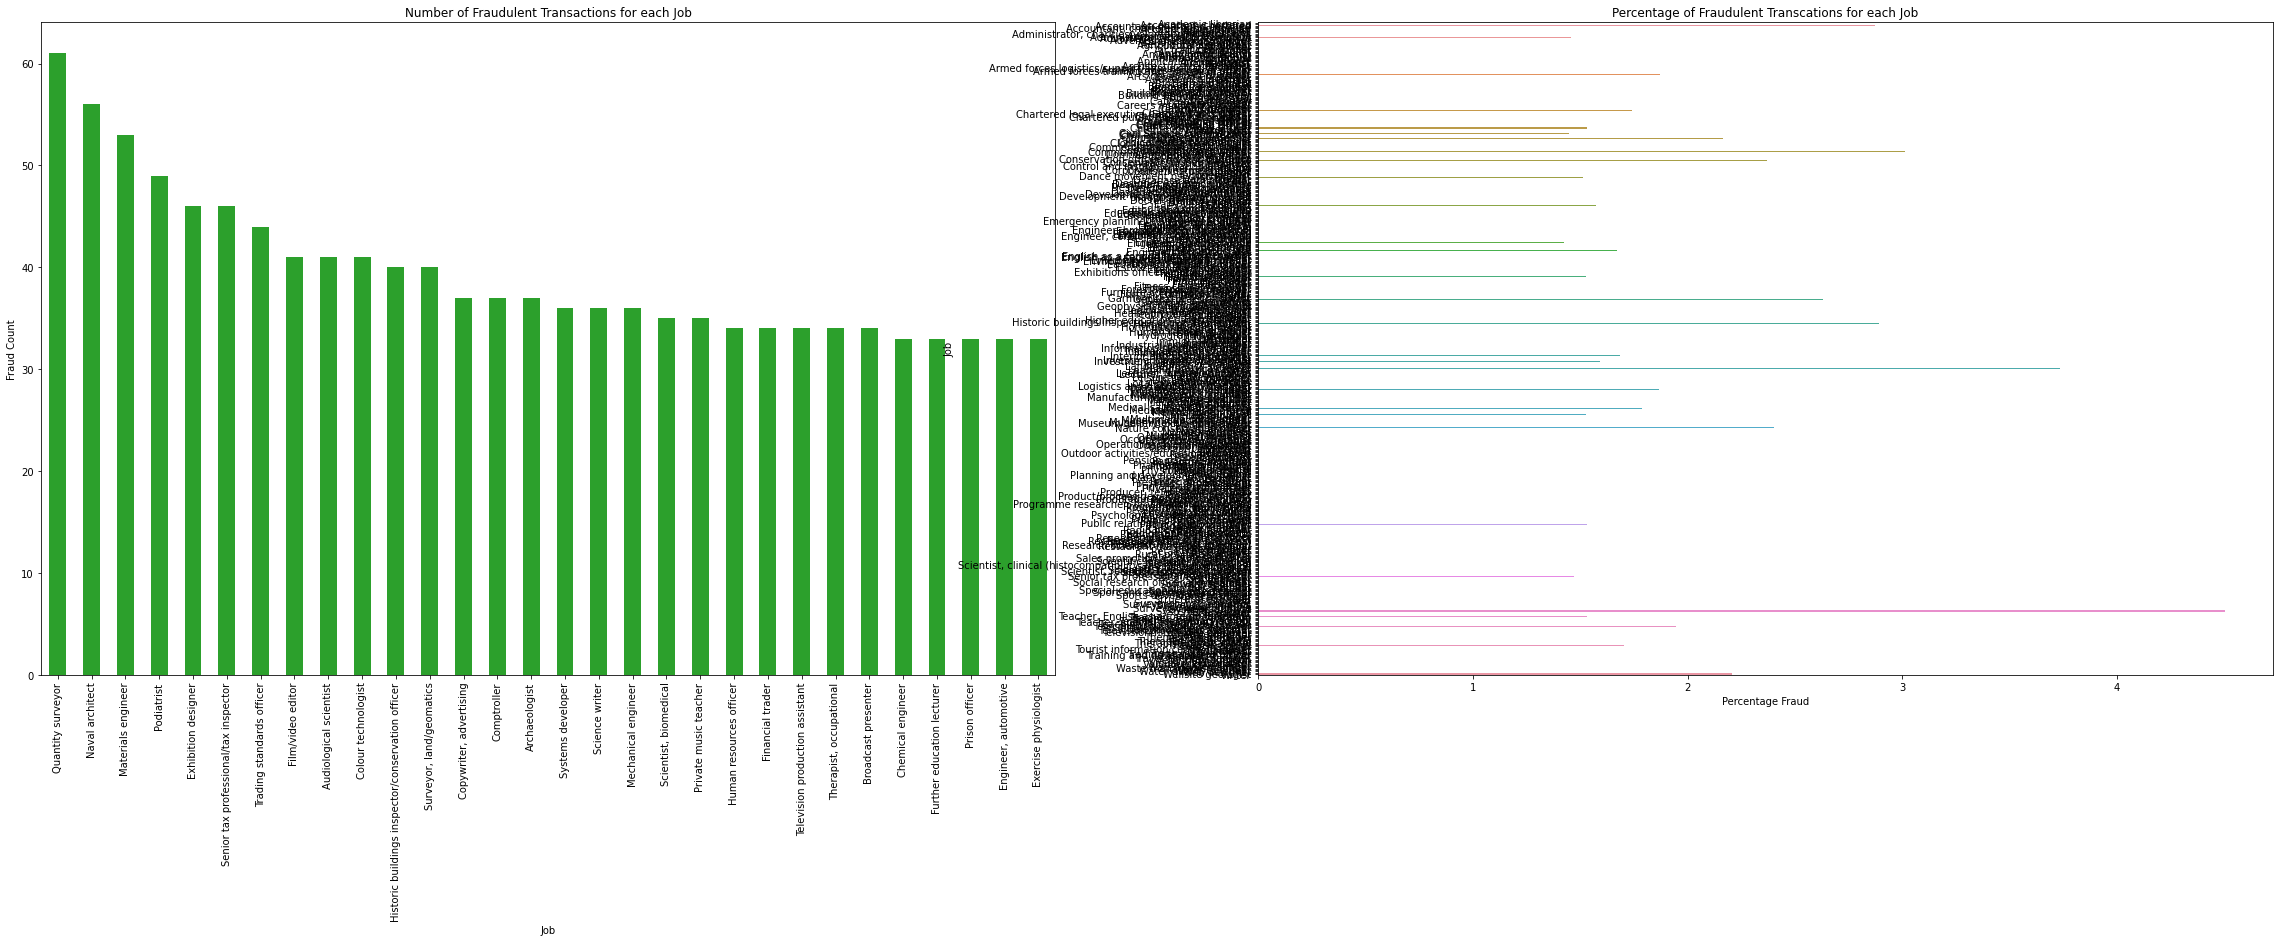

In [17]:
fig, ax = plt.subplots(1,2,figsize=(40,12))

# Plotting the number of fraud transactions for each job
onlyFraud.job.value_counts(sort=True,ascending=False).head(30).plot(kind="bar",color="tab:green", ax=ax[0])
ax[0].set_xlabel('Job')
ax[0].set_ylabel('Fraud Count')
ax[0].set(title='Number of Fraudulent Transactions for each Job')

# Plotting the Percentage of fraud transactions for each job
g=train.job.value_counts()
g=g.to_frame()
g=g.reset_index()
g.columns = ['Job', 'Total Count']

h=onlyFraud.job.value_counts()
h=h.to_frame()
h=h.reset_index()
h.columns = ['Job', 'Fraud Count']

merged4=g.merge(h,on='Job')
merged4['Percentage Fraud']=merged4['Fraud Count']/merged4['Total Count']
merged4['Percentage Fraud']=merged4['Percentage Fraud']*100
merged4=merged4.sort_values('Percentage Fraud',ascending=False)

# ignore those jobs with too low total count
merged4=merged4.loc[merged4["Total Count"] > 100]

# since there are too many jobs, we only look at the top 30
merged4=merged4[:30]

sns.barplot(data=merged4, x='Percentage Fraud',y='Job', ax=ax[1])
ax[1].set_xlabel('Percentage Fraud')
ax[1].set_ylabel('Job')
ax[1].set(title='Percentage of Fraudulent Transcations for each Job')

plt.show()

Jobs with the highest number of fraud transactions: Quantity Surveyor, Naval Architect, Materials Engineer

Jobs with the highest percentage of fraud transactions: TEFL Teacher, Lawyer, Community Development Worker

## Gender

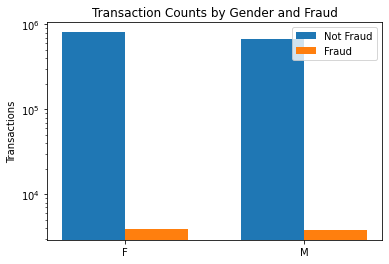

In [18]:
data = train[["gender","is_fraud","amt"]]
data = data.groupby([data.gender, data.is_fraud], as_index=False).count()

labels = data["gender"].unique()
tempLocation = np.arange(len(labels))
width = 0.35  # the width of the bars

noFraudValues = []
fraudValues = []
for a in data["gender"].unique():
  barData = data.loc[data.gender == a]
  quantityNotFraud = data.loc[(data.gender == a) & (data.is_fraud == 0)].amt
  noFraudValues.append(quantityNotFraud.iloc[0])
  if len(barData["is_fraud"]) == 2:
    quantityFraud = data.loc[(data.gender == a) & (data.is_fraud == 1)].amt
    fraudValues.append(quantityFraud.iloc[0])
  else:
    fraudValues.append(0)

fig, ax = plt.subplots()
bar1 = ax.bar(
    tempLocation - width/2,
    noFraudValues, 
    width, 
    label='Not Fraud'
    )
bar2 = ax.bar(
    tempLocation + width/2, 
    fraudValues,
    width, 
    label='Fraud'
    )    
ax.set_ylabel('Transactions')
ax.set_title('Transaction Counts by Gender and Fraud')
ax.set_xticks(tempLocation)
ax.set_xticklabels(labels)
ax.legend()
plt.yscale("log")

plt.show()

No significant difference visually.

## Category

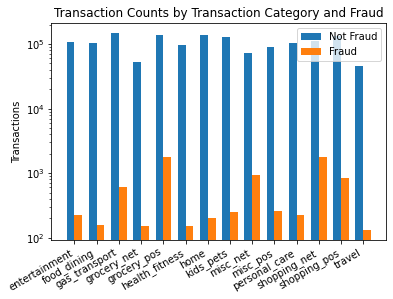

In [19]:
data = train[["category","is_fraud","amt"]]
data = data.groupby([data.category, data.is_fraud], as_index=False).count()

labels = data["category"].unique()
tempLocation = np.arange(len(labels))
width = 0.35

noFraudValues = []
fraudValues = []
for a in data["category"].unique():
  barData = data.loc[data.category == a]
  quantityNotFraud = data.loc[(data.category == a) & (data.is_fraud == 0)].amt
  noFraudValues.append(quantityNotFraud.iloc[0])
  if len(barData["is_fraud"]) == 2:
    quantityFraud = data.loc[(data.category == a) & (data.is_fraud == 1)].amt
    fraudValues.append(quantityFraud.iloc[0])
  else:
    fraudValues.append(0)

fig, ax = plt.subplots()
bar1 = ax.bar(
    tempLocation - width/2,
    noFraudValues, 
    width, 
    label='Not Fraud'
    )
bar2 = ax.bar(
    tempLocation + width/2, 
    fraudValues,
    width, 
    label='Fraud'
    )    
ax.set_ylabel('Transactions')
ax.set_title('Transaction Counts by Transaction Category and Fraud')
ax.set_xticks(tempLocation)
ax.set_xticklabels(labels)
ax.legend()
plt.yscale("log")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

More fraud for grocery_pos, shopping_pos, shopping_net, misc_net.

Generally POS and NET sales are more fraud prone???

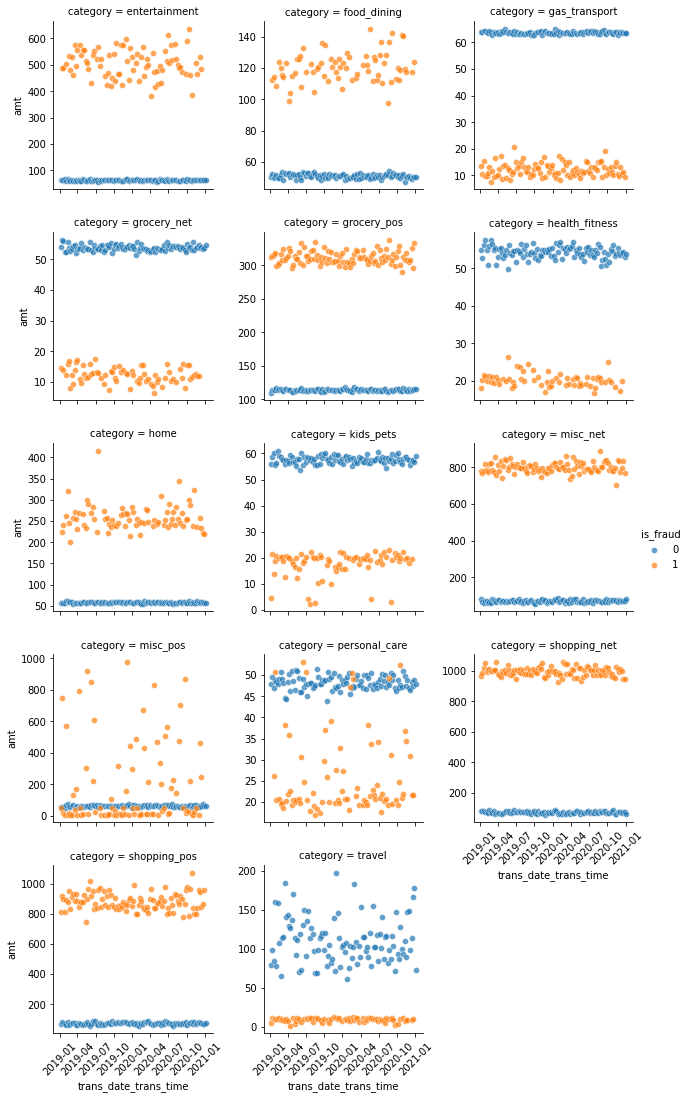

In [20]:
train["trans_date_trans_time"] = pd.to_datetime(train["trans_date_trans_time"], infer_datetime_format=True)
category_df = train.groupby(by=[pd.Grouper(key="trans_date_trans_time", freq="1W"),
                           'is_fraud','category']).agg({"amt":'mean',"trans_num":"count"}).reset_index()

g = sns.FacetGrid(category_df, col="category", hue="is_fraud", col_wrap=3, sharey=False)
g.map(sns.scatterplot, "trans_date_trans_time", "amt", alpha=.7)
g.set_xticklabels(rotation=45)
g.add_legend()

We can see that across the different categories, there are clear distinctions in the amount spent (when aggregated by week). For example, looking at the `grocery_net` category, fraudulent transactions are likely to only have a small aggregated amount spent, whereas non-fraudulent transactions have a higher aggregated amount.

Of course, this difference is not that distinct across all the categories. For example, for the category of `misc_pos`, the difference in aggregated amounts is not that distinct. Regardless, this can be a differentiating factor and an important feature to be included in the machine learning model.

## Weekday

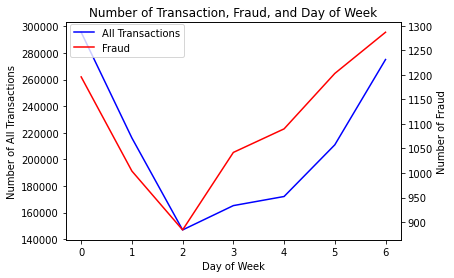

In [21]:
train.is_fraud = train.is_fraud.astype("float")
groupedStep = train.groupby("weekday", as_index=False).agg({"amt": "count", "is_fraud": "sum"})
train.is_fraud = train.is_fraud.astype("category")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(groupedStep.weekday, groupedStep.amt, color="blue", label="All Transactions")
ax2.plot(groupedStep.weekday, groupedStep.is_fraud, color="red", label="Fraud")
plt.title('Number of Transaction, Fraud, and Day of Week')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Number of All Transactions')
ax2.set_ylabel('Number of Fraud')
plt.ticklabel_format(axis="y", style='plain')
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.9))

plt.show()

We observe a higher proportion of fraud transactions from Wed-Sat.

## Date

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[Text(81.125, 0.5, 'Amount'),
 Text(0.5, 33.00000000000005, 'Date'),
 Text(0.5, 1.0, 'Aggregated Amount for Non-Fraudulent Transactions by Date')]

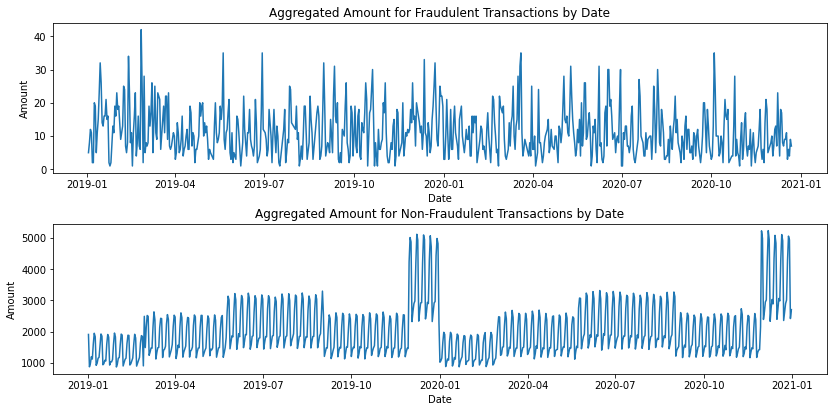

In [22]:
onlyFraud.is_fraud = onlyFraud.is_fraud.astype("float")
noFraud.is_fraud = noFraud.is_fraud.astype("float")
df = onlyFraud.groupby(by="date").agg({"amt": "count"}).reset_index()
df2 = noFraud.groupby(by="date").agg({"amt": "count"}).reset_index()
onlyFraud.is_fraud = onlyFraud.is_fraud.astype("category")
noFraud.is_fraud = noFraud.is_fraud.astype("category")

fig, ax = plt.subplots(2, 1, figsize=(12,6))
fig.tight_layout(pad=3.0)
ax[0].plot(df["date"], df["amt"])
ax[0].set(xlabel="Date", ylabel="Amount", title="Aggregated Amount for Fraudulent Transactions by Date")
ax[1].plot(df2["date"], df2["amt"])
ax[1].set(xlabel="Date", ylabel="Amount", title="Aggregated Amount for Non-Fraudulent Transactions by Date")

Looking at the aggregated amounts across each date, we can see that for the non-fraudulent transactions, there is a distinct seasonality to the series. 

Firstly, the amount peaks each week (during the weekend), and this cycle repeats every week. Next, we can see that for the periods of November-December, the average amount spent is higher than that during the other months. 

However, for the fraudulent transactions, we see that there is no distinct pattern/seasonality to the data. Instead, it seems to be relatively volatile. Hence, the aggregated amount by date might also be a useful informative feature to be added to the machine learning model.

## YrMth

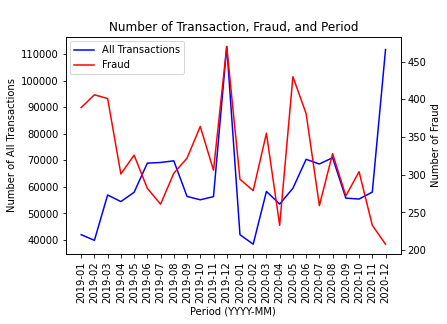

In [23]:
train.is_fraud = train.is_fraud.astype("float")
groupedStep = train.groupby("trans_yrmth", as_index=False).agg({"amt": "count", "is_fraud": "sum"})
train.is_fraud = train.is_fraud.astype("category")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(groupedStep.trans_yrmth, groupedStep.amt, color="blue", label="All Transactions")
ax2.plot(groupedStep.trans_yrmth, groupedStep.is_fraud, color="red", label="Fraud")
plt.title('Number of Transaction, Fraud, and Period')
ax1.set_xticklabels(groupedStep.trans_yrmth, rotation=90)
ax1.set_xlabel('Period (YYYY-MM)')
ax1.set_ylabel('Number of All Transactions')
ax2.set_ylabel('Number of Fraud')
plt.ticklabel_format(axis="y", style='plain')
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 1))

plt.show()

Number of fraud transactions generally functuates but decrease overall. It peaked in December 2019 and May 2020. 

In December 2019, it has the highest number of transactions and fraud transactions. However, in December 2020, it has the highest number of transactions but lowest number of fraud transactions.

## Hour

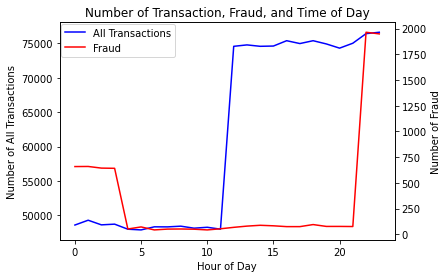

In [24]:
train.is_fraud = train.is_fraud.astype("float")
groupedStep = train.groupby("trans_hour", as_index=False).agg({"amt": "count", "is_fraud": "sum"})
train.is_fraud = train.is_fraud.astype("category")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(groupedStep.trans_hour, groupedStep.amt, color="blue", label="All Transactions")
ax2.plot(groupedStep.trans_hour, groupedStep.is_fraud, color="red", label="Fraud")
plt.title('Number of Transaction, Fraud, and Time of Day')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of All Transactions')
ax2.set_ylabel('Number of Fraud')
plt.ticklabel_format(axis="y", style='plain')
fig.legend(loc="upper left", bbox_to_anchor=(0.13, 0.9))

plt.show()

Higher incidence of fraud from 22 to 03 hours.

## Age Grp

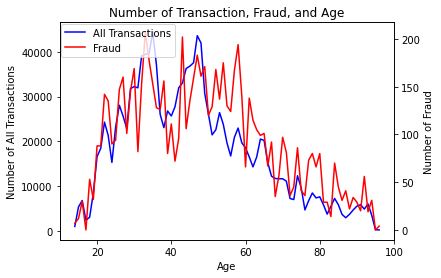

In [25]:
# For Age
train.is_fraud = train.is_fraud.astype("float")
groupedStep = train.groupby("age", as_index=False).agg({"amt": "count", "is_fraud": "sum"})
train.is_fraud = train.is_fraud.astype("category")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(groupedStep.age, groupedStep.amt, color="blue", label="All Transactions")
ax2.plot(groupedStep.age, groupedStep.is_fraud, color="red", label="Fraud")
plt.title('Number of Transaction, Fraud, and Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of All Transactions')
ax2.set_ylabel('Number of Fraud')
plt.ticklabel_format(axis="y", style='plain')
fig.legend(loc="upper left", bbox_to_anchor=(0.13, 0.9))

plt.show()

Higher incidence of fraud above age of 50.

## Distance

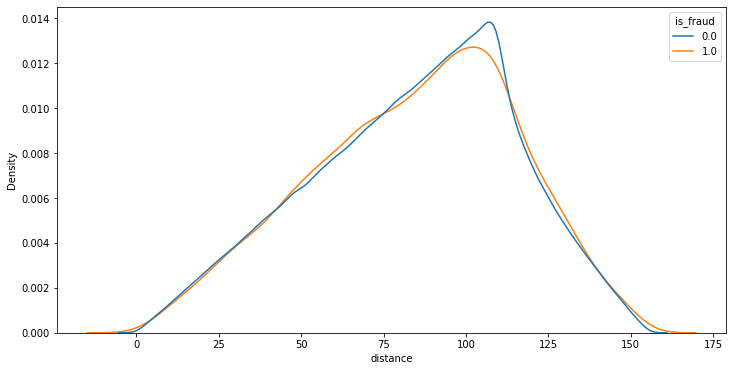

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

sns.kdeplot(data=train.reset_index(), x="distance", hue="is_fraud", common_norm=False)

# After EDA (dropping)

In [ ]:
train.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
train.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

validation.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
validation.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

test.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
test.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

train

,category,amt,gender,city,state,job,is_fraud,age_group,trans_hour,trans_yrmth,weekday,distance
1089385,shopping_net,9.11,M,Pembroke,NC,Hospital doctor,0,60 to 70,7,2020-03,6,88.270416
396245,gas_transport,75.57,F,Centerview,MO,Electronics engineer,0,30 to 40,1,2019-06,6,117.115063
816379,misc_net,390.37,M,Oakland,TN,Furniture conservator/restorer,0,20 to 30,5,2019-12,6,56.383604
476241,shopping_pos,96.55,F,Lakeport,CA,Podiatrist,0,40 to 50,12,2020-12,0,108.142655
567642,kids_pets,13.78,M,San Antonio,TX,Exhibition designer,0,40 to 50,20,2019-08,3,98.590270
...,...,...,...,...,...,...,...,...,...,...,...,...
1286615,misc_pos,6.88,F,Sutherland,NE,Insurance broker,0,30 to 40,23,2020-06,1,62.997041
926319,shopping_net,98.85,F,Steuben,ME,Make,0,60 to 70,3,2020-01,3,122.501992
83164,misc_pos,10.48,F,Tulsa,OK,Bookseller,0,50 to 60,9,2020-07,0,82.202315
301454,travel,6.45,F,Allentown,PA,"Scientist, research (maths)",0,20 to 30,23,2019-05,6,22.751546


# Models

While each individual's model performance and hyperparameter tuning is elaborated in greater detail in their individual notebooks, we include the two best models that we have found to this section, as a summary.

## Baseline Performance (Validation Set)

In [ ]:
from math import sqrt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Track the performance of various models
performance_tracker = pd.DataFrame(columns=["Model Name", "Training Time", "Accuracy", "Recall", "Precision", "F1", "ROC AUC"])

# Always predict Not Fraud
y_pred = pd.Series(0).repeat(validation.is_fraud.size)
performance_tracker.loc["Naive Model (Always Not Fraud)"] = ["Naive Model (Always Not Fraud)", 0.0, accuracy_score(validation.is_fraud, y_pred), recall_score(validation.is_fraud, y_pred), precision_score(validation.is_fraud, y_pred), f1_score(validation.is_fraud, y_pred), roc_auc_score(validation.is_fraud, y_pred)]

# Always predict Fraud
y_pred = pd.Series(1).repeat(validation.is_fraud.size)
performance_tracker.loc["Naive Model (Always Fraud)"] = ["Naive Model (Always Fraud)", 0.0, accuracy_score(validation.is_fraud, y_pred), recall_score(validation.is_fraud, y_pred), precision_score(validation.is_fraud, y_pred), f1_score(validation.is_fraud, y_pred), roc_auc_score(validation.is_fraud, y_pred)]

performance_tracker

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Naive Model (Always Not Fraud),Naive Model (Always Not Fraud),0.0,0.994726,0.0,0.000000,0.000000,0.5
Naive Model (Always Fraud),Naive Model (Always Fraud),0.0,0.005274,1.0,0.005274,0.010493,0.5


## CatBoost

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier
import time

x_train = train[train.columns[~train.columns.isin(["is_fraud"])]]
categorical_variables = ['category', 'gender', 'city', 'state', 'job', 'age_group', 'trans_hour', 'trans_yrmth', 'weekday']

clf = CatBoostClassifier(cat_features=categorical_variables,
                         random_state=4012)

start_time = time.perf_counter()
clf.fit(x_train, train.is_fraud)
training_time = time.perf_counter() - start_time


In [ ]:
x_test = test[test.columns[~test.columns.isin(["is_fraud"])]]

y_pred = clf.predict(x_test)
performance_tracker.loc["CatBoost"] = ["CatBoost", training_time, accuracy_score(test.is_fraud, y_pred), recall_score(test.is_fraud, y_pred), precision_score(test.is_fraud, y_pred), f1_score(test.is_fraud, y_pred), roc_auc_score(test.is_fraud, y_pred)]
performance_tracker

,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Naive Model (Always Not Fraud),Naive Model (Always Not Fraud),0.000000,0.994726,0.000000,0.000000,0.000000,0.50000
Naive Model (Always Fraud),Naive Model (Always Fraud),0.000000,0.005274,1.000000,0.005274,0.010493,0.50000
CatBoost,CatBoost,2840.060282,0.999660,0.951446,0.982924,0.966929,0.97568


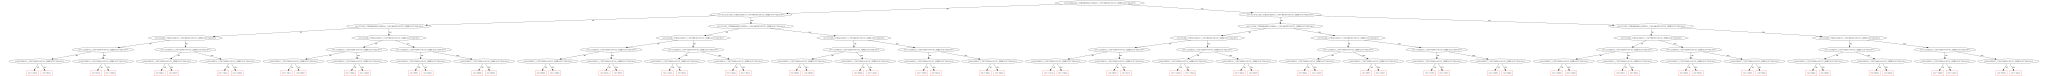

In [ ]:
from catboost import Pool

pool = Pool(x_train, train.is_fraud, cat_features=categorical_variables, feature_names=list(x_train.columns))
tree = clf.plot_tree(tree_idx=999, pool=pool)
tree

In [ ]:
!pip install shap
import shap

shap_values = clf.get_feature_importance(Pool(x_test, label=test.is_fraud,cat_features=categorical_variables), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], x_test.iloc[3,:])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 23.6 MB/s 


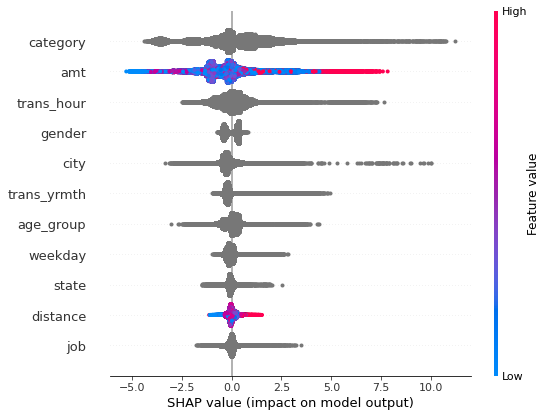

In [ ]:
shap_values = clf.get_feature_importance(Pool(x_test, label=test.is_fraud,cat_features=categorical_variables), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, x_test)

## LGBM

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier

# Define the model pipeline
model = LGBMClassifier(class_weight="balanced", random_state=4012, num_leaves=30, n_estimators=1215)

# Train and time the model
time_start = time.perf_counter()
model.fit(x_train, train.is_fraud, eval_set=[(x_test, test.is_fraud), (x_train, train.is_fraud)], verbose=25)
training_time = time.perf_counter() - time_start

# Generate predictions on test data
y_pred = pd.Series(model.predict(x_test))

# Evaluate and record model performance
performance_tracker.loc["LGBM"] = ["LGBM", training_time, accuracy_score(test.is_fraud, y_pred), recall_score(test.is_fraud, y_pred), precision_score(test.is_fraud, y_pred), f1_score(test.is_fraud, y_pred), roc_auc_score(test.is_fraud, y_pred)]
performance_tracker

[25]	training's binary_logloss: 0.0917771	valid_0's binary_logloss: 0.100362
[50]	training's binary_logloss: 0.0350768	valid_0's binary_logloss: 0.0428044
[75]	training's binary_logloss: 0.0170932	valid_0's binary_logloss: 0.0220206
[100]	training's binary_logloss: 0.0104604	valid_0's binary_logloss: 0.0141985
[125]	training's binary_logloss: 0.00691661	valid_0's binary_logloss: 0.00999041
[150]	training's binary_logloss: 0.00494451	valid_0's binary_logloss: 0.00766016
[175]	training's binary_logloss: 0.00356411	valid_0's binary_logloss: 0.00596672
[200]	training's binary_logloss: 0.00272138	valid_0's binary_logloss: 0.00494976
[225]	training's binary_logloss: 0.0021635	valid_0's binary_logloss: 0.00433199
[250]	training's binary_logloss: 0.0017327	valid_0's binary_logloss: 0.00387481
[275]	training's binary_logloss: 0.00140726	valid_0's binary_logloss: 0.00352026
[300]	training's binary_logloss: 0.00114714	valid_0's binary_logloss: 0.00326754
[325]	training's binary_logloss: 0.0009427

,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
Naive Model (Always Not Fraud),Naive Model (Always Not Fraud),0.00000,0.994726,0.000000,0.000000,0.000000,0.500000
Naive Model (Always Fraud),Naive Model (Always Fraud),0.00000,0.005274,1.000000,0.005274,0.010493,0.500000
LGBM,LGBM,266.79063,0.999325,0.933884,0.936788,0.935334,0.966777


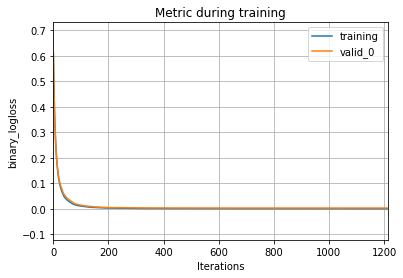

In [ ]:
from lightgbm import plot_metric
plot_metric(model)

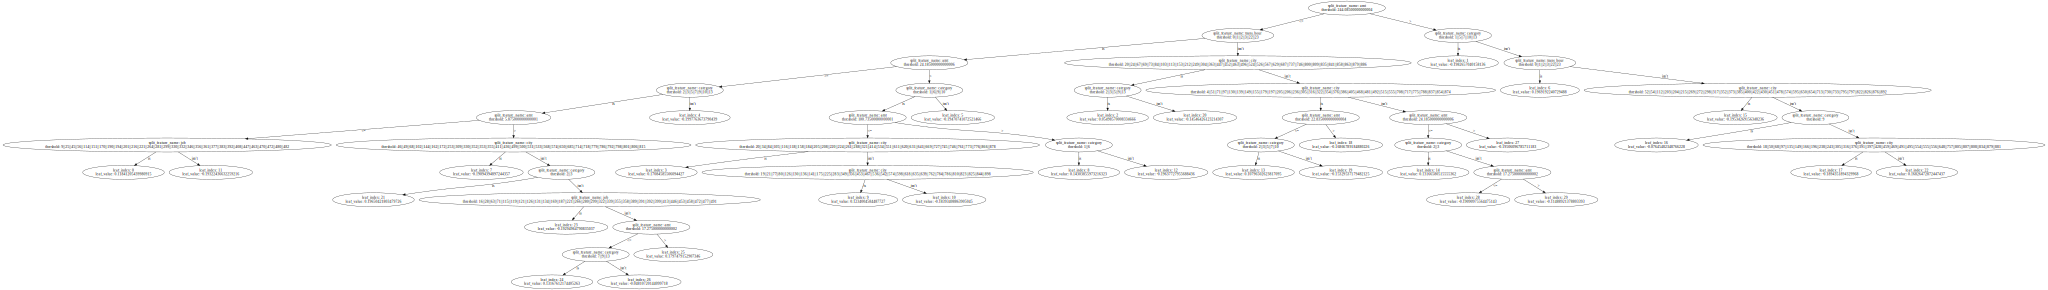

In [ ]:
from lightgbm import create_tree_digraph
create_tree_digraph(model)

In [ ]:
time_start = time.perf_counter()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[test.columns[~test.columns.isin(["is_fraud"])]])
shap_values_df = pd.DataFrame(shap_values[1], columns="shap_" + test[test.columns[~test.columns.isin(["is_fraud"])]].columns)
X_test_with_shap = pd.concat([test[test.columns[~test.columns.isin(["is_fraud"])]].reset_index(drop=True), shap_values_df], axis=1)
training_time = time.perf_counter() - time_start
training_time

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


1203.4694345060002

In [ ]:
X_test_with_shap.groupby(["trans_hour"])["shap_trans_hour"].agg(["mean"]).sort_values(by="mean", ascending=False)

,mean
trans_hour,
23,3.133676
22,2.979889
0,1.525349
2,1.408149
3,1.169108
1,1.022881
13,-0.158381
5,-0.282706
12,-0.285627


In [ ]:
X_test_with_shap.groupby(["category"])["shap_category"].agg(["mean"]).sort_values(by="mean", ascending=False)

,mean
category,
misc_pos,1.488443
food_dining,1.126068
kids_pets,1.041810
gas_transport,0.866046
personal_care,0.759541
health_fitness,0.636595
grocery_net,0.467477
travel,-0.288776
home,-0.524411


In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

@interact
def shap_decision_plot(Customer=widgets.IntSlider(value=0, min=0, max=len(test[test.columns[~test.columns.isin(["is_fraud"])]].index)-1, step=1)):
    actual = test.is_fraud.iloc[Customer]
    predicted = y_pred.iloc[Customer]
    error = "True" if actual == predicted else "False"
    pos_neg = "Positive" if predicted == 1 else "Negative"
    shap.decision_plot(explainer.expected_value[1], shap_values[1][Customer,:], test[test.columns[~test.columns.isin(["is_fraud"])]].iloc[Customer,:], link="logit")
    print("Actual Default = " + str(actual) + ", Predicted Default = " + str(predicted) + " (" + error + " " + pos_neg + ")")

interactive(children=(IntSlider(value=0, description='Customer', max=185239), Output()), _dom_classes=('widget…